In [14]:
import sys
sys.path.append('../../')

In [15]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *


In [4]:
XAUUSD = {}
XAUUSD['H4'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv',index_col='Time',parse_dates=True)
XAUUSD['H1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H1'] + '.csv', index_col='Time',parse_dates=True)

In [5]:
start_date = '2007-01-01'
end_date = '2008-01-01'

In [6]:
for i in TIMEFRAME :
    XAUUSD[i].index.name = None
    XAUUSD[i] = XAUUSD[i].loc[start_date:end_date]

In [5]:
XAUUSD['H4']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240


In [37]:
class Inside_Bar(Strategy) :
    ATR_SL = 0.5
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, 20)['ATR']
        self.data.df['sma_fast'] = SMA(self.data.df,50,200)['sma_fast']
        
        self.data.df['inside_bar'] = np.where(((self.data.df['High'] < self.data.df['High'].shift(
            1)) & (self.data.df['Low'] > self.data.df['Low'].shift(1))), True, False)



    def next(self):
        pre_inside_bar = False
        current_inside_bar = False
        if len(self.data.df) >= 3:
            current_inside_bar = self.data.df.loc[self.data.df.index[-2], 'inside_bar']
            pre_inside_bar = self.data.df.loc[self.data.df.index[-3], 'inside_bar']
        sma_fast = self.data.df.loc[self.data.df.index[-2], 'sma_fast']
        sma_low = self.data.df.loc[self.data.df.index[-2], 'sma_slow']
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if current_inside_bar == True and pre_inside_bar == True and not self.position and sma_fast >= sma_low and self.data.Close > self.data.Open:
            tp = self.data.Close + current_ATR * self.ATR_SL
            sl = self.data.Close - current_ATR * self.ATR_SL
            # Place your buy logic here
            self.buy(sl=sl, tp=tp, size=1)

        if current_inside_bar == True and pre_inside_bar == True and not self.position and sma_fast <= sma_low and self.data.Close < self.data.Open:
            tp = self.data.Close - current_ATR * self.ATR_SL
            sl = self.data.Close + current_ATR * self.ATR_SL
               
            self.sell(sl=sl, tp=tp, size=1)

In [7]:
account_size = 20000

In [38]:
bt = Backtest(XAUUSD['H4'], Inside_Bar, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    2.821836
Equity Final [$]                   19959.7075
Equity Peak [$]                  20019.190475
Return [%]                          -0.201463
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.010077
Volatility (Ann.) [%]                0.094219
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.397324
Avg. Drawdown [%]                   -0.148914
Max. Drawdown Duration     5618 days 20:00:00
Avg. Drawdown Duration     1935 days 16:00:00
# Trades                                  513
Win Rate [%]                        50.097466
Best Trade [%]                       0.587102
Worst Trade [%]                     -1.210448
Avg. Trade [%]                    

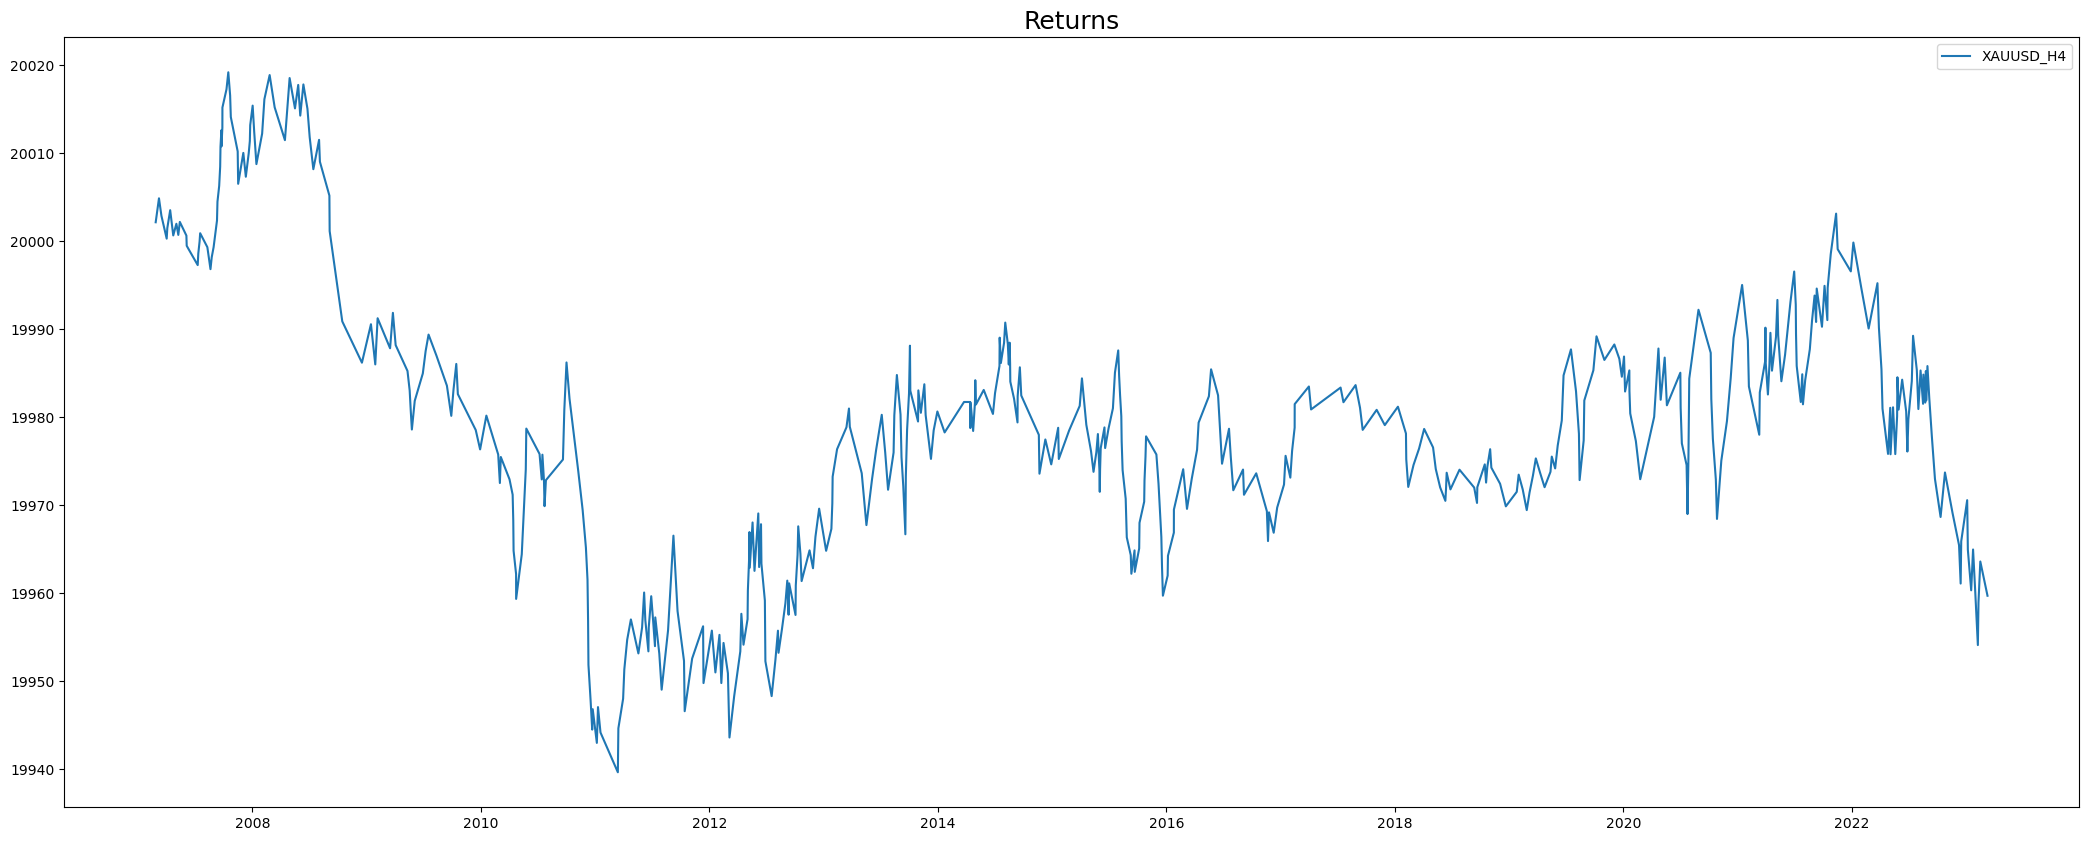

In [39]:
plot_return_trades(result['_trades'],'XAUUSD_H4' , account_size)

In [40]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='3447', ...)